# Mini-Xrays: Multi-label Classification from DataFrames

Replicating `planet.ipynb` from Fastai part1 v1 and v2, using [mini-xray dataset](https://www.kaggle.com/kmader/create-a-mini-xray-dataset-standard/data) instead of images of the Amazon. This notebook details a multi-label classification problem of predicting 15 labels including 14 lung abnormality labels and one no finding label. The images are extracted and stored in `data/raw` and the labels are saved as `data/labels.csv`.

## Imports

In [36]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

#usual stuff
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import shutil
from PIL import Image as pil_image
import warnings
warnings.filterwarnings("ignore")

#utils
import h5py

#fastai
import fastai
from fastai import *         
from fastai.vision import * 

#paths
DATA_PATH = 'data/'
TRAIN_PATH = f'{DATA_PATH}train/'
VALID_PATH = f'{DATA_PATH}valid/'
RAW_PATH = f'{DATA_PATH}raw/'
MODEL_PATH = f'{DATA_PATH}models/'

#check cuda
print(f'PyTorch version {torch.version.__version__}')
print(f'CUDA is {torch.cuda.is_available()}')
print(f'CuDnn is {torch.backends.cudnn.enabled}')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PyTorch version 1.0.0.dev20180929
CUDA is True
CuDnn is True


## Process Data

Exract the [mini-xray dataset](https://www.kaggle.com/kmader/create-a-mini-xray-dataset-standard/data) downloaded as `chest_xray.h5`.

In [2]:
# with h5py.File(f'{DATA_PATH}chest_xray.h5', 'r') as h5_data:
#     for c_key in h5_data.keys():
#         print(c_key, h5_data[c_key].shape, h5_data[c_key].dtype)

In [3]:
# result = []
# with h5py.File(f'{DATA_PATH}chest_xray.h5', 'r') as h5_data:
#     images = h5_data['images'].value
#     fnames = h5_data['path'].value
#     targets = h5_data['Finding Labels'].value

In [4]:
# extract metadata
# meta = []
# for i in range(len(fnames)):
#     meta.append({'fname':fnames[i].astype(str).split('/')[-1],'target':targets[i].astype(str)})
# meta = pd.DataFrame(meta)
# meta['flag'] = meta['target'].map(lambda x: 1 if x else 0)
# meta['target'] = meta['target'].map(lambda x: str(x).replace('|', ' '))
# meta.to_csv(f'{DATA_PATH}labels.csv',index=False)
meta = pd.read_csv(f'{DATA_PATH}labels.csv')
meta.head()

,fname,target,flag
0,00020213_066.png,Infiltration,1
1,00030279_000.png,Atelectasis Cardiomegaly,1
2,00005490_001.png,Atelectasis Consolidation Pneumothorax,1
3,00013472_002.png,Atelectasis Consolidation Effusion Infiltratio...,1
4,00005089_035.png,Effusion,1


## Data Bunch

Create `DataBunch` object with selected transformations, size and batch size.

In [5]:
#transformation
tfms = [flip_lr(p=0.5),
        rotate(degrees=(-10,10), p=0.5), 
        rand_zoom(scale=(1.,1.1), p=0.75), 
        contrast(scale=(0.8, 1/0.8), p=0.75)]

#get data bunch
data = ImageDataBunch.from_df(path = DATA_PATH, #data path
                              df = meta, #df containing labels
                              folder = 'raw', #folder containing images
                              valid_pct = 0.2, #validation set percentage
                              ds_tfms=(tfms, []),  #transformations for training and validation sets
                              size = 128, bs = 64) #input image size and batch size

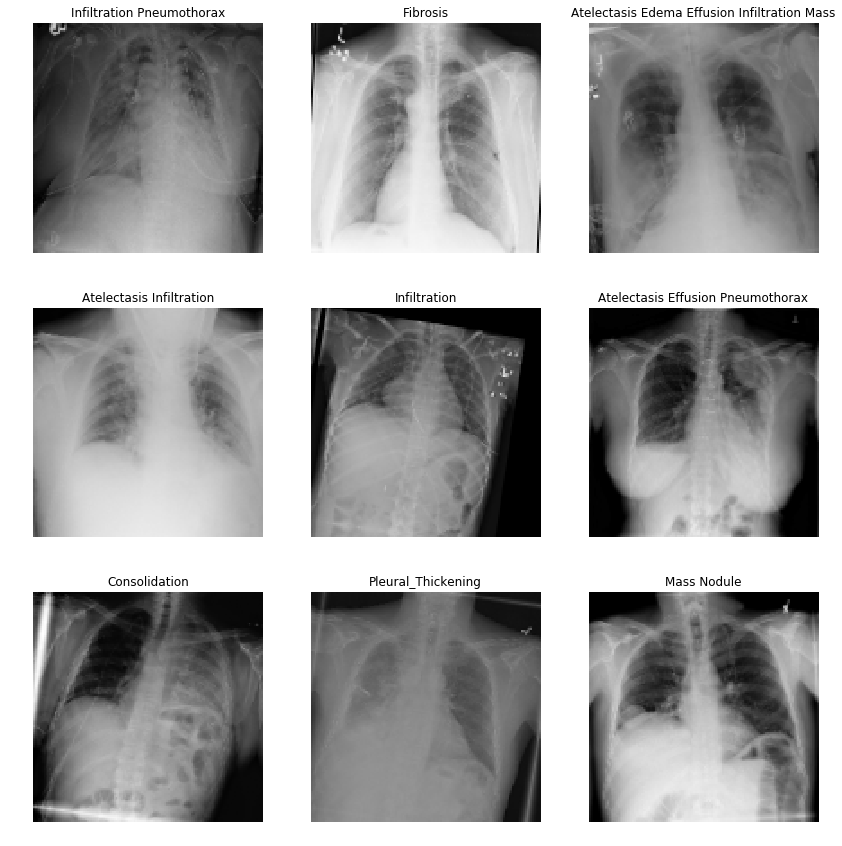

In [6]:
img,label = data.train_dl.one_batch() #load one batch
show_images(img.cpu(), label.cpu(), 3, data.train_ds.classes, figsize=(12,12)) #show image of that batch with transformations

In [ ]:
#normalize images
data.normalize(imagenet_stats)

## Learner

Select maximum learning rates and weight decays. Load pretrained models. Warm up with one epoch then unfreeze and train all layers.

In [8]:
opt_fn = partial(optim.Adam, betas=(0.9, 0.99)) #optimizer
loss_fn = partial(F.cross_entropy, weight = None) #loss function
learn = ConvLearner(data, tvm.resnet34, metrics=[accuracy]) #create learner object based on pretrained resnet34
learn.opt_fn = opt_fn
learn.loss_fn = loss_fn

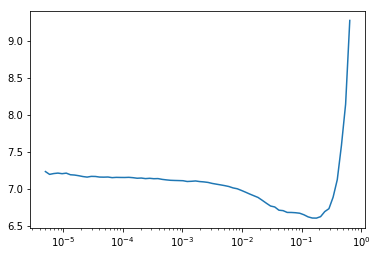

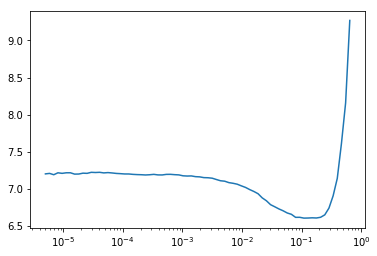

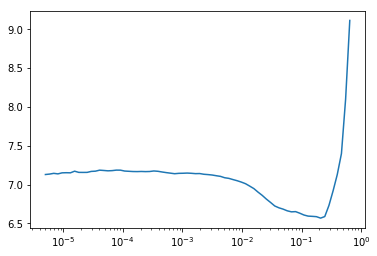

In [9]:
#select weight decays and lrs
wds = [1e-6,1e-4,1e-2]
for wd in wds:
    learn.wd = wd
    learn.lr_find(start_lr = 1e-6, end_lr = 1e1)
    learn.recorder.plot()

In [10]:
#select maximum learning rate one-tenth of the point where it goes crazy
#select weight decay that allows highest maximum learning rates
wd = 1e-4
lr = 0.2 / 10
lrs = (lr/1e3, lr/1e3, lr)
wds = (wd/1e4,wd/1e4,wd)

In [11]:
#train one cycle to warm up
learn.fit_one_cycle(cyc_len = 1, 
                    max_lr=lrs, #discriminative learning rates
                    moms = (0.95,0.85), #momentums
                    div_factor=25, #factor to discount from max
                    pct_start = 0.3, #where the peak is at 
                    wd=wds #discriminative weight decays
                   ) 

Total time: 00:44
epoch  train loss  valid loss  accuracy
0      4.382618    4.269759    0.125385  (00:44)



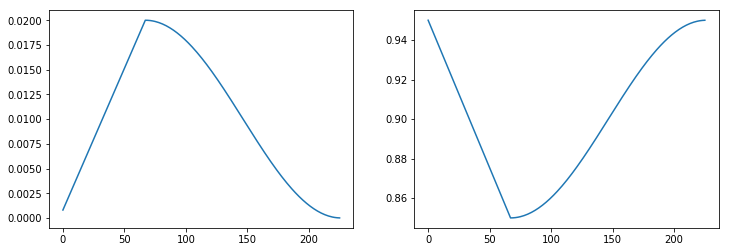

In [12]:
#learning rate and momentum during training
learn.recorder.plot_lr(show_moms=True)

In [13]:
#unfreeze and train all layers
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=lrs, moms = (0.95,0.85), div_factor=25, pct_start = 0.3, wd=wds)
learn.save('128_resnet34_oc10')

Total time: 09:48
epoch  train loss  valid loss  accuracy
0      4.286682    4.266397    0.134061  (00:59)
1      4.274587    4.281994    0.142737  (00:58)
2      4.288118    4.476125    0.136300  (00:58)
3      4.285910    4.264720    0.136300  (00:58)
4      4.267236    4.309469    0.141338  (00:58)
5      4.100910    4.190198    0.158970  (00:58)
6      3.988643    4.290191    0.156731  (00:58)
7      3.856384    4.296708    0.158410  (00:58)
8      3.765811    4.215019    0.160369  (00:58)
9      3.653940    4.116177    0.161769  (00:58)



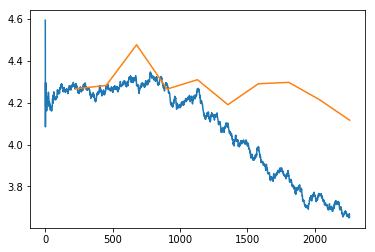

In [14]:
#train and validation loss
learn.recorder.plot_losses()

## Evaluation

In [15]:
preds,y = learn.TTA(is_test=False) #test time augmentation
# preds,y = learn.get_preds() #no test time augmentation

Total time: 00:41



In [18]:
interp = ClassificationInterpretation(data, preds, y, loss_class=nn.CrossEntropyLoss)

In [38]:
accuracy(preds,y), fbeta(preds,y.reshape(-1,1), beta=2), fbeta(preds,y.reshape(-1,1), beta=1)

(tensor(0.1620), tensor(13.7323), tensor(16.8810))